# Visualisierung von Studierendendaten
In diesem Projekt wird mit anonymisierten und aus Datenschutzgründen verzerrten Studierendendaten gearbeitet.  Enthalten sind Informationen wie Studienstatus, absolvierte ECTS-Punkte pro Semester und viele andere Informationen, jeweils auf Semesterbasis.

Zweck ist, sinnvolle Darstellungen zu finden, die von wenig statistisch geschulten Personen gelesen und eventuell sogar interaktiv „verwendet“ werden können. Eine Herausforderung besteht in der sinnvollen Darstellung bzw. Hervorhebung tlw. geringer Fallzahlen. 

### Annahmen / Ziele

• Studierende mit internationalem Hintergrund studieren länger. (weil ihnen z.B. durch mangelnde Informationen/Unterstützung Hürden im Studium gestellt werden)<br>
• ECTS-Punkte nehmen über den Studienverlauf hinweg ab, um dann gegen Ende wieder anzusteigen.<br>
• Explorativ: Unterschiede zwischen Studiengängen, Identifikation von ECTS-schwachen und ECTS-intensiven Semestern bestimmter Studiengänge

### Prozessschritte

• <b>acquire & parse</b>: Erforderte nur Anonymisierung eines vorhandenen CSV mittels R scripts<br>
• <b>analyze/visualize</b>: seaborn, plotly, plotly express<br>
• <b>interact</b>: Dash und plotly express<br>
• <b>deployment</b>: eventuell Heroku

In [2]:
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import ipywidgets as widgets

In [3]:
df_raw = pd.read_csv("student_dummy_data.csv", delimiter=";", encoding="latin-1", decimal=",")

In [4]:
# [print(element) for element in df_raw.columns]
df_raw.columns

Index(['MATRIKELNUMMER', 'STUDBEZ', 'ZULAC', 'SEMESTER_ID', 'STUDIENJAHR',
       'ST_SEM_NR', 'StudienStatusCode', 'StatusgruppeS', 'StatusgruppeSem1',
       'STUDBEZ_kompakt', 'Studart', 'Studgruppe', 'FAMILIENNAME', 'VORNAME',
       'GESCHLECHT', 'LAND_1', 'STUDDAUER', 'OUTGOINGSEM', 'Beginndat_Min',
       'Endedat_Max', 'besuchtesSemester', 'Alter', 'Ueberlaenge',
       'StatusgruppeR', 'ECTS_Sem', 'SWS_Sem', 'ECTS_Sj', 'SWS_Sj', 'prfakt',
       'IncomingsemUHSBV'],
      dtype='object')

In [5]:
df = df_raw.copy()
df["Land"] = "International"
# Variable that splits students in two groups based on Austrian citizenship
df.loc[df['LAND_1'] == "Österreich", 'Land'] = "Österreich"

In [6]:
# Producing an aggregated dataframe grouped by semester and field of study
df_by_semester_and_study_grps = df.groupby(["besuchtesSemester", "STUDBEZ_kompakt"])
df_by_semester_and_study_agg = df_by_semester_and_study_grps["ECTS_Sem"].agg(["mean", "median"])
df_by_semester_and_study_agg = pd.DataFrame(df_by_semester_and_study_agg).reset_index()
df_by_semester_and_study_agg["mean"] = df_by_semester_and_study_agg["mean"].round(1)
df_by_semester_and_study_agg = df_by_semester_and_study_agg.astype({"besuchtesSemester": int})


## Studiendauer unter Berücksichtigung von Staatsangehörigkeit
Hier werden alle Beobachtungen (=Semester) mit dem Status "Studienabschluss" betrachtet.

In [7]:
# filtering only the final semesters (containing the status "Studienabschluss")
final_semesters = df.loc[df["StatusgruppeR"] == "Studienabschluss"]
#sns.barplot(data = final_semesters, x="Land", y="besuchtesSemester")

# checking the distribution of "internationality" in a specific field of study
final_semesters.loc[final_semesters["STUDBEZ_kompakt"] == "BA; BI"]["Land"].value_counts()

Österreich       59
International     2
Name: Land, dtype: int64

Text(16, 2.1, 'nur 2 Fälle')

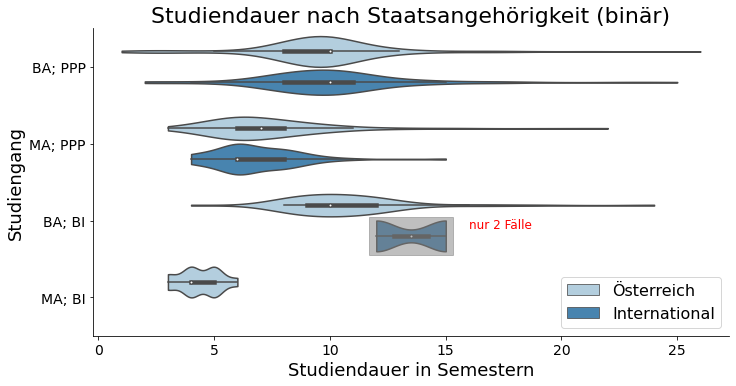

In [8]:
order_of_studies = ["BA; PPP", "MA; PPP", "BA; BI", "MA; BI"]

myplot = sns.catplot(data=final_semesters, 
            kind="violin", 
            y="STUDBEZ_kompakt",
            order=order_of_studies,
            x="besuchtesSemester",
            hue="Land", 
            cut=0, 
            bw=0.4, 
            legend=False, # legend can not be positioned using sns.catplot
            orient="h", 
            aspect=2, 
            palette="Blues")
# setting & adjusting title, labels, legend (incl. fontsizes)
plt.title("Studiendauer nach Staatsangehörigkeit (binär)", fontdict={"size":"22"})
plt.ylabel("Studiengang", fontdict={"size":"18"})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Studiendauer in Semestern", fontdict={"size":"18"})
plt.legend(loc="lower right",prop={'size': 16})

# getting figure object so gca can be applied
fig = myplot.figure

# this positioning is super clumsy but works for (only) this figure
fig.gca().add_patch(Rectangle((11.7,1.95),3.6,0.5,fill=True, color='gray', alpha=0.5, zorder=100, figure=fig))
plt.text(16, 2.1, "nur 2 Fälle", fontdict={"color": "red", "size":"12"})


Nur in zwei der vier Studiengänge kann die Studiendauer verglichen werden. Im Bachelor "Business Intelligence" sowie im dazugehörigen Masterstudium sind kaum internationale Studierende (2 bzw. 0 respektive).

Rein basierend auf dieser Visualisierung kann man kaum behaupten, dass internationale Studierende länger studieren.

<b>Annahme 1 kann also insgesamt nicht bestätigt werden.</b>

### Herausforderungen

<b>Theoret. Ebene</b>
- Wie - auf visueller Ebene - umgehen mit kleinen Fallzahlen, die die Ergebnisse stark verzerren?
- Wie kommuniziert man diese Einschränkungen an nicht statistisch geschulte Personen?

<b>Techn. Ebene</b>
- Seaborn hat eingeschränkte Möglichkeiten, z.B. was die Positionierung der Legende angeht --> Kombination mit matplotlib tlw. tricky
- Schwergefallen ist mir die Postitionierung des Rechteckes im Plot: Erst muss man sich das figure-Objekt holen und dann darauf basierend die Achsen durch die "gca"-Methode

### ECTS-Aufwand im X. Semester nach Staatsangehörigkeit

In [9]:
def ects_vio_plot(dataframe = df, selected_semester=1):
    """
    creates a violin plot showing ECTS during the chosen semester 
    and comparing all fields of study, split by nationality
    can be used with the original df (as provided by our common export)
    """
    df_reduced = dataframe.loc[dataframe["besuchtesSemester"] == selected_semester]
    p = sns.catplot(data=df_reduced, 
    kind="violin",
    x="besuchtesSemester", 
    y="ECTS_Sem",
    hue="Land",
    col="STUDBEZ_kompakt",
    col_order=order_of_studies,
    #col_wrap=2,
    palette="Blues",
    cut=0, 
    split=True, 
    legend=None)
    p.set_axis_labels("", "absolvierte ECTS-Punkte", size=16)
    p.set_titles("{col_name}", size=20)
    p.fig.subplots_adjust(top=0.8)
    p.fig.suptitle(f"Absolvierte ECTS-Punkte im {selected_semester}. Semester", size=26)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0, fontsize="x-large")
    return(p)

In [10]:
"""
small menu to pick a semester to create violin plot for
"""
menu = widgets.Dropdown(
    options=[1,2,3,4,5,6,7,8],
    value=1,
    description="Semester:"
)


In [11]:
menu

Dropdown(description='Semester:', options=(1, 2, 3, 4, 5, 6, 7, 8), value=1)

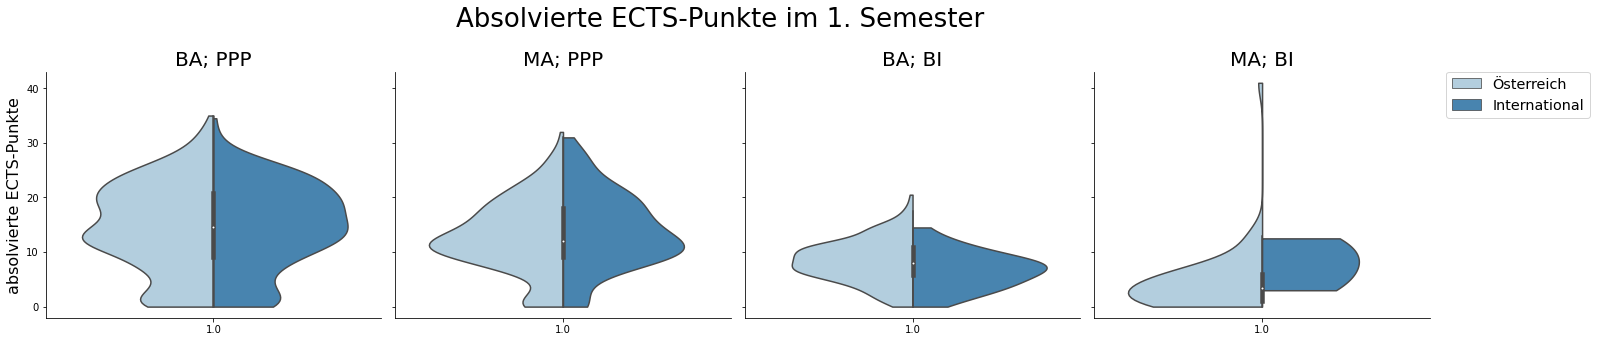

In [12]:
ects_vio_plot(df, selected_semester=menu.value)



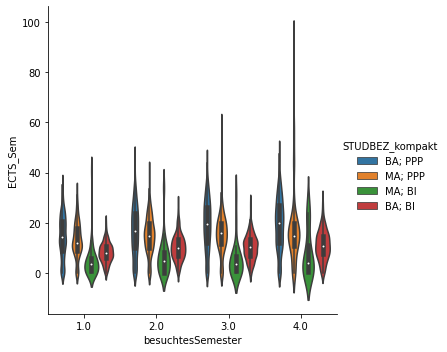

In [13]:
max_sem = 4
df_reduced = df.loc[df["besuchtesSemester"] <= max_sem]
sns.catplot(data=df_reduced, 
            kind="violin", 
            x="besuchtesSemester",
            y="ECTS_Sem", 
            hue="STUDBEZ_kompakt", 
            )
 
#plt.ylim(0,60)

# would be useful to introduce trim, so that we "zoom in" more

In [14]:
# sns.catplot(data=df_reduced, kind="violin", x="STUDBEZ_kompakt", y="ECTS_Sem", hue="besuchtesSemester")

In [15]:
#df_raw.loc[df_raw["StatusgruppeR"] != "Beurlaubung"]

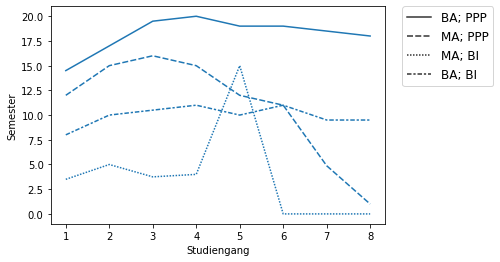

In [16]:
max_sem = 8
sns.lineplot(data=df_raw.loc[(df_raw["StatusgruppeR"] != "Beurlaubung") &
                            (df_raw["besuchtesSemester"] <= max_sem)], 
            x="besuchtesSemester", 
            y="ECTS_Sem", 
            #hue="STUDBEZ_kompakt", 
            ci=None, 
            estimator="median", 
            style="STUDBEZ_kompakt")
plt.xlabel("Studiengang")
plt.ylabel("Semester")
#plt.legend(loc="best")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0, fontsize="large")

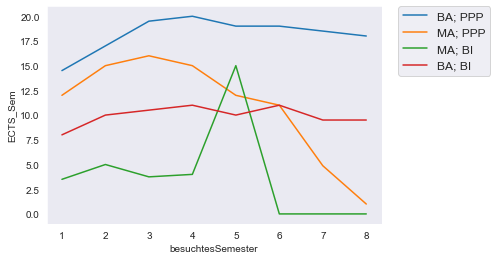

In [17]:
max_sem = 8
sns.set_style("dark")
sns.lineplot(data=df_raw.loc[df_raw.besuchtesSemester <= max_sem], 
            x="besuchtesSemester", 
            y="ECTS_Sem", 
            hue="STUDBEZ_kompakt", 
            ci=None, 
            estimator="median")
plt.xticks(df_raw.loc[df_raw.besuchtesSemester <= max_sem]["besuchtesSemester"].unique())
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0, fontsize="large")

<b>Weitere Bearbeitung durch interaktiven Plot mit plotly/plotly express und Dash</b>